<a href="https://colab.research.google.com/github/ogueke/image_classification/blob/main/Plant_classification_project_ChatKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_dir = '/content/drive/MyDrive/Dataset'

def convert_img_to_df(dataset):
  img_dir = Path(dataset)
  filename = list(img_dir.glob(r'**/*.*'))
  label = list(map(lambda x:os.path.split(os.path.split(x)[0])[1],filename))

  filename = pd.Series(filename,name='Filepath').astype(str)
  label = pd.Series(label,name='Label')
  img_df = pd.concat([filename,label],axis=1)
  return img_df

img_df = convert_img_to_df(data_dir)
img_df.head()

,Filepath,Label
0,/content/drive/MyDrive/Dataset/Non-Plant Part/...,Non-Plant Part
1,/content/drive/MyDrive/Dataset/Non-Plant Part/...,Non-Plant Part
2,/content/drive/MyDrive/Dataset/Non-Plant Part/...,Non-Plant Part
3,/content/drive/MyDrive/Dataset/Non-Plant Part/...,Non-Plant Part
4,/content/drive/MyDrive/Dataset/Non-Plant Part/...,Non-Plant Part


In [44]:
img = plt.imread(img_df['Filepath'].iloc[1])
img.shape

(160, 160, 3)

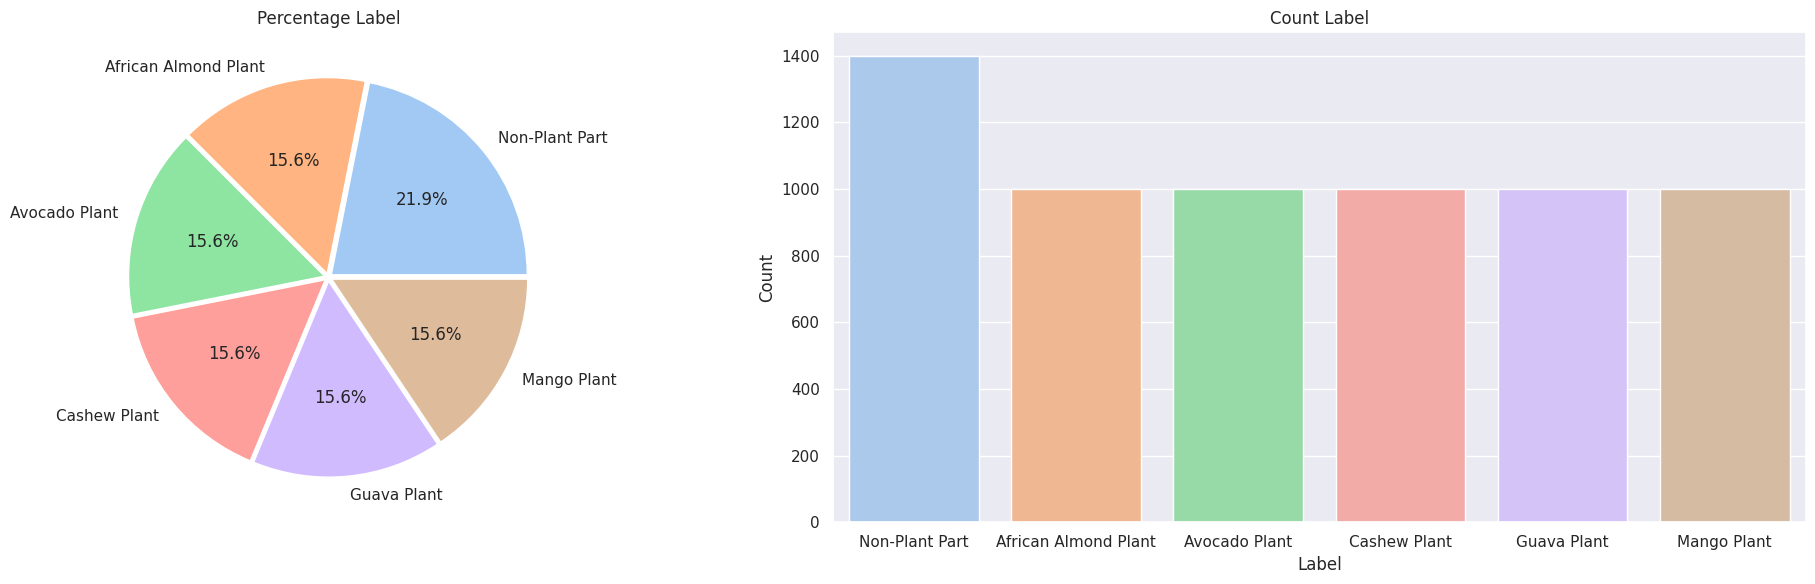

In [45]:
#Label Count
label_count = img_df['Label'].value_counts()

#Setting
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')
explode = [0.02]*len(label_count)

#Pie chart
axes[0].pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', colors=color, explode=explode)
axes[0].set_title('Percentage Label')

#Barplot
sns.barplot(x=label_count.index, y=label_count.values, ax=axes[1])
axes[1].set_title('Count Label')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

#Show
plt.tight_layout()
plt.show()

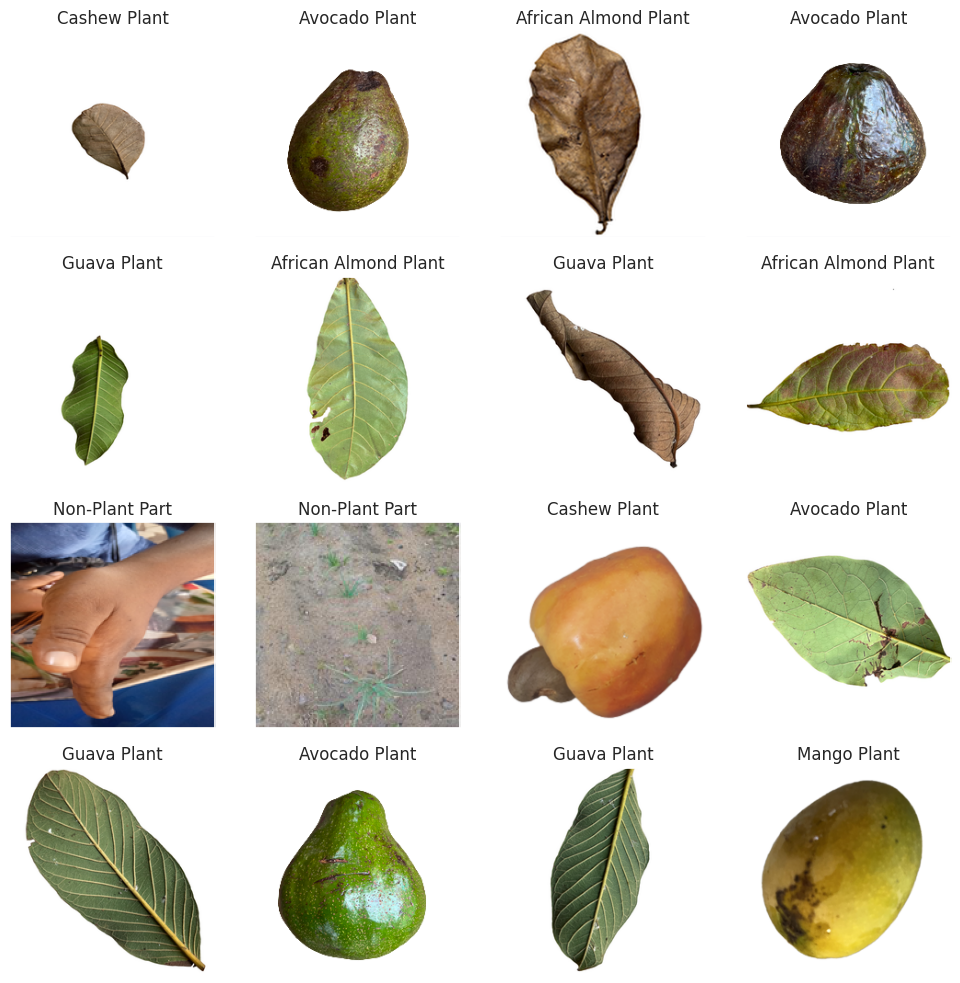

In [46]:
random_index = np.random.randint(0,len(img_df),16)
fig,axes = plt.subplots(nrows=4,ncols=4,figsize=(10,10),subplot_kw={'xticks':[],'yticks':[]})

for i,ax in enumerate(axes.flat):
  img = plt.imread(img_df['Filepath'].iloc[random_index[i]])
  ax.imshow(img)
  ax.set_title(img_df['Label'].iloc[random_index[i]])
plt.tight_layout()
plt.show()

In [50]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

#Split data
img_train , test = train_test_split(img_df,test_size=0.2)
train, val = train_test_split(img_train,test_size=0.2)

#For train
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range = 40,
                             horizontal_flip=True
)
# For test
datagen_test = ImageDataGenerator(rescale=1./255)

train_set = datagen.flow_from_dataframe(dataframe=train,
                                        x_col='Filepath',
                                        y_col='Label',
                                        batch_size=32,
                                        target_size=(224,224),
                                        shuffle=True,
                                        seed=42,
                                        class_mode='categorical'
                                        )

val_set = datagen_test.flow_from_dataframe(dataframe=val,
                                        x_col='Filepath',
                                        y_col='Label',
                                        batch_size=32,
                                        target_size=(224,224),
                                        shuffle=True,
                                        seed=42,
                                        class_mode='categorical'
                                        )

test_set = datagen_test.flow_from_dataframe(dataframe=test,
                                        x_col='Filepath',
                                        y_col='Label',
                                        batch_size=32,
                                        target_size=(224,224),
                                        shuffle=False,
                                        seed=42,
                                        class_mode='categorical'
                                        )

Found 4095 validated image filenames belonging to 6 classes.
Found 1024 validated image filenames belonging to 6 classes.
Found 1280 validated image filenames belonging to 6 classes.


In [63]:
from keras import Sequential
from keras.layers import Dense, MaxPool2D,Conv2D,Flatten,Dropout

model = Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D((2,2),padding='same'))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D((2,2),padding='same'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D((2,2),padding='same'))

model.add(Flatten())
model.add(Dropout(0.45))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(6,activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 conv2d_33 (Conv2D)          (None, 220, 220, 32)      4640      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 110, 110, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 108, 108, 64)      18496     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 52, 52, 128)      

In [64]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(train_set,
                    steps_per_epoch=len(train_set),
                    validation_data=val_set,
                    validation_steps=len(val_set),
                    epochs=20,
                    verbose=1)

Epoch 1/20
128/128 [==============================] - 66s 490ms/step - loss: 1.3916 - accuracy: 0.4786 - val_loss: 0.8509 - val_accuracy: 0.6934
Epoch 2/20
128/128 [==============================] - 68s 532ms/step - loss: 0.8019 - accuracy: 0.6974 - val_loss: 0.6095 - val_accuracy: 0.8086
Epoch 3/20
128/128 [==============================] - 72s 565ms/step - loss: 0.6733 - accuracy: 0.7578 - val_loss: 0.6023 - val_accuracy: 0.7891
Epoch 4/20
128/128 [==============================] - 65s 505ms/step - loss: 0.5292 - accuracy: 0.8093 - val_loss: 0.4133 - val_accuracy: 0.8564
Epoch 5/20
128/128 [==============================] - 71s 553ms/step - loss: 0.4800 - accuracy: 0.8374 - val_loss: 0.3910 - val_accuracy: 0.8730
Epoch 6/20
128/128 [==============================] - 99s 770ms/step - loss: 0.4166 - accuracy: 0.8454 - val_loss: 0.3424 - val_accuracy: 0.8750
Epoch 7/20
128/128 [==============================] - 66s 510ms/step - loss: 0.4514 - accuracy: 0.8391 - val_loss: 0.3579 - val_ac

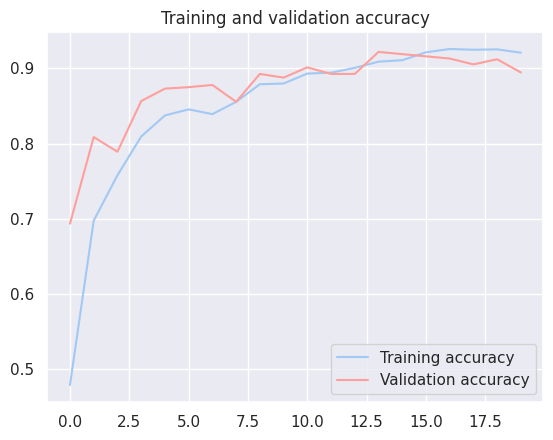

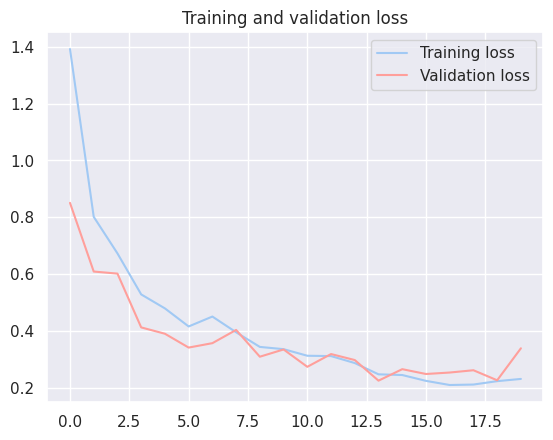

In [65]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [66]:
#Model Evaluation using the test dataset
results = model.evaluate(test_set, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.29575
Test Accuracy: 90.78%


In [67]:
# Predict the label of the test_images
pred = model.predict(test_set)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

40/40 [==============================] - 5s 114ms/step
The first 5 predictions: ['Cashew Plant', 'Guava Plant', 'African Almond Plant', 'Mango Plant', 'African Almond Plant']


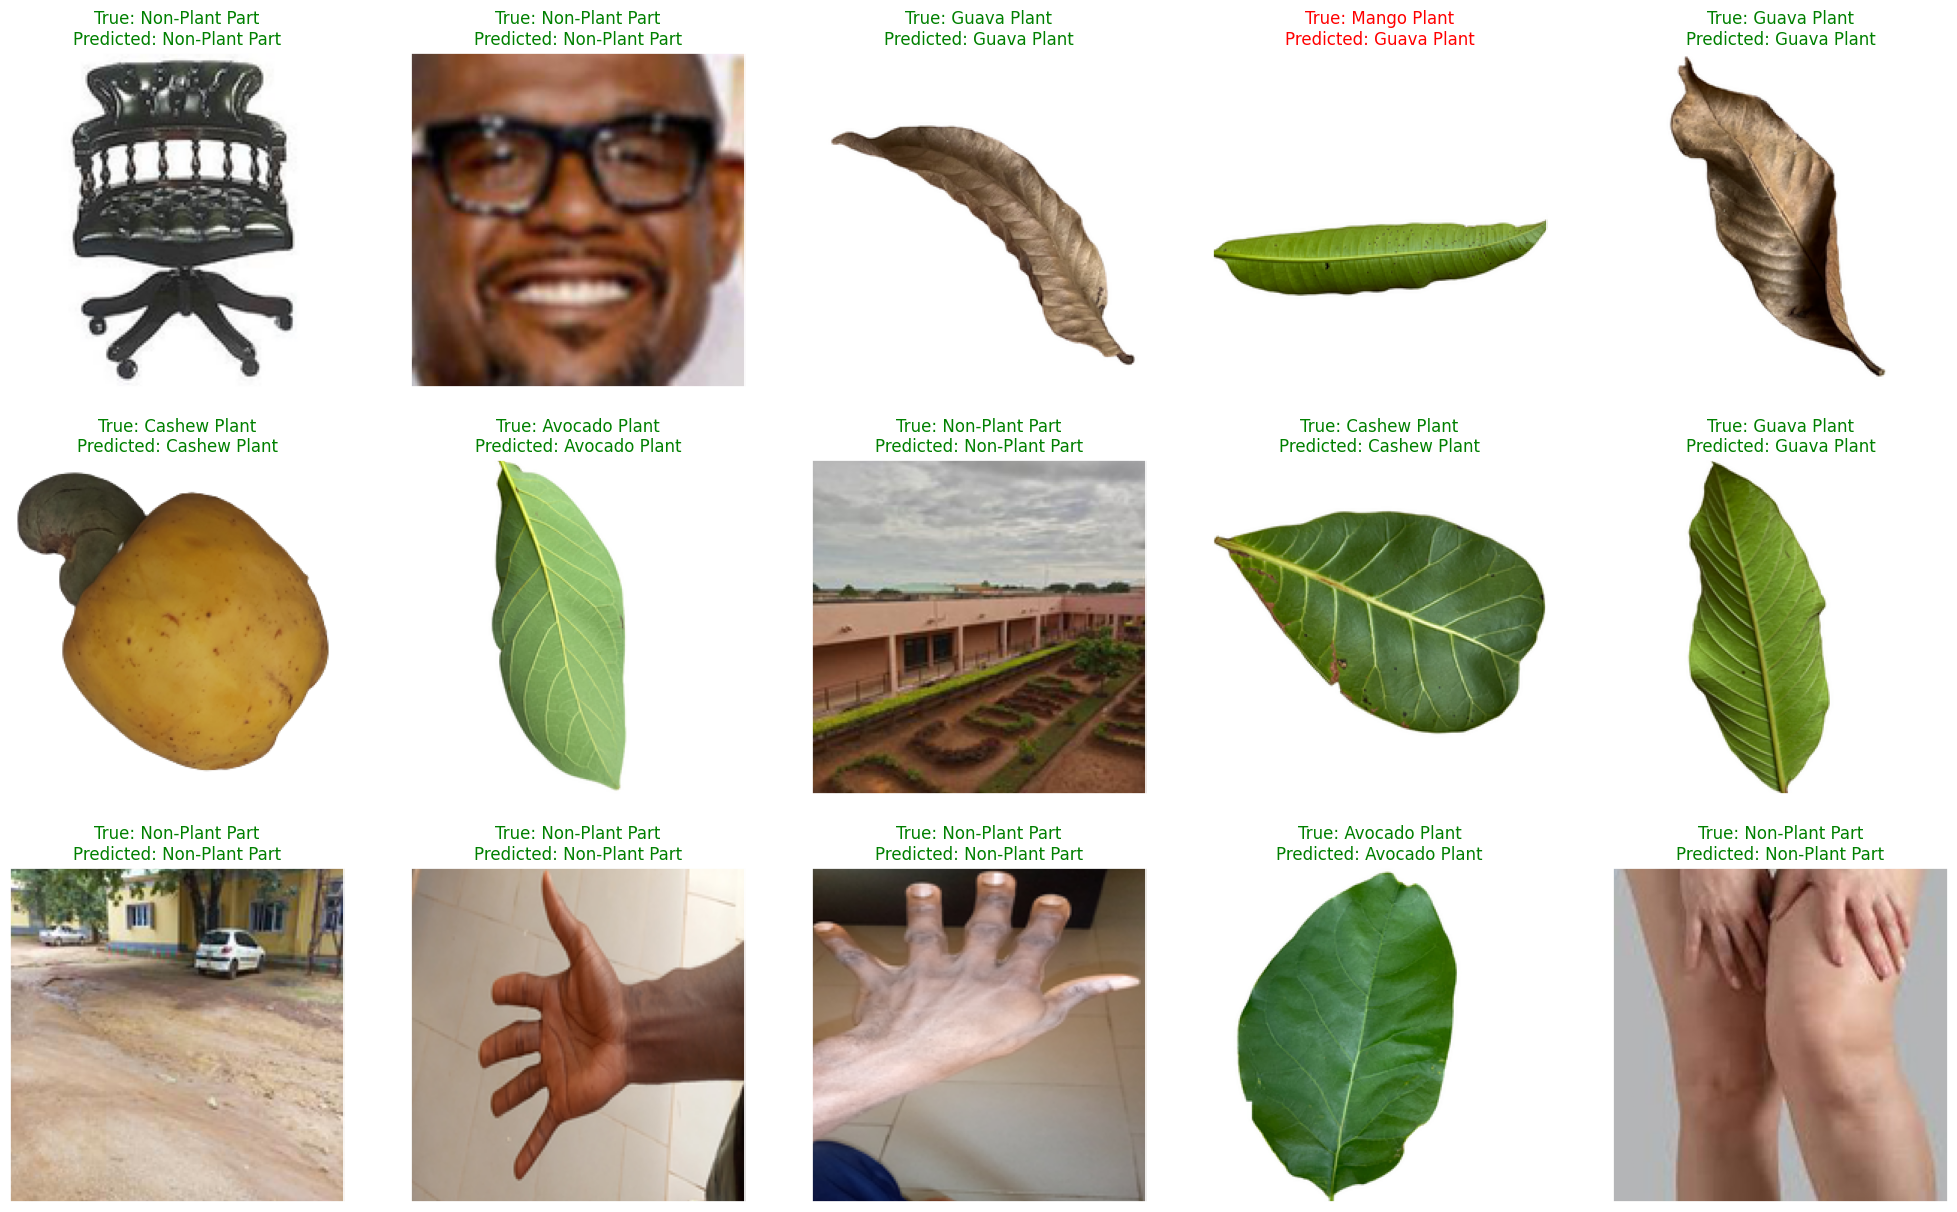

<Figure size 640x480 with 0 Axes>

In [68]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[random_index[i]]))
    if test.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [69]:
# Performance Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools
y_test = list(test.Label)
print(classification_report(y_test, pred))

                      precision    recall  f1-score   support

African Almond Plant       0.93      0.93      0.93       187
       Avocado Plant       0.95      0.76      0.84       197
        Cashew Plant       0.83      0.97      0.89       209
         Guava Plant       0.80      0.91      0.85       201
         Mango Plant       0.96      0.92      0.94       189
      Non-Plant Part       0.99      0.95      0.97       297

            accuracy                           0.91      1280
           macro avg       0.91      0.90      0.90      1280
        weighted avg       0.91      0.91      0.91      1280



In [70]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
African Almond Plant,0.930481,0.930481,0.930481,187.000000
Avocado Plant,0.949045,0.756345,0.841808,197.000000
Cashew Plant,0.831276,0.966507,0.893805,209.000000
Guava Plant,0.798246,0.905473,0.848485,201.000000
Mango Plant,0.955801,0.915344,0.935135,189.000000
Non-Plant Part,0.992958,0.949495,0.970740,297.000000
accuracy,0.907813,0.907813,0.907813,0.907813
macro avg,0.909634,0.903941,0.903409,1280.000000
weighted avg,0.914610,0.907813,0.907998,1280.000000


In [71]:
cm = confusion_matrix(y_test, pred)
print(cm)

[[174   5   0   7   1   0]
 [  7 149  16  21   2   2]
 [  0   0 202   7   0   0]
 [  0   0  14 182   5   0]
 [  1   0   6   9 173   0]
 [  5   3   5   2   0 282]]


In [72]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  import itertools

  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy

  if cmap is None:
      cmap = plt.get_cmap('Blues')

  plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
      tick_marks = np.arange(len(target_names))
      plt.xticks(tick_marks, target_names, rotation=90)
      plt.yticks(tick_marks, target_names)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")


  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
  plt.show()

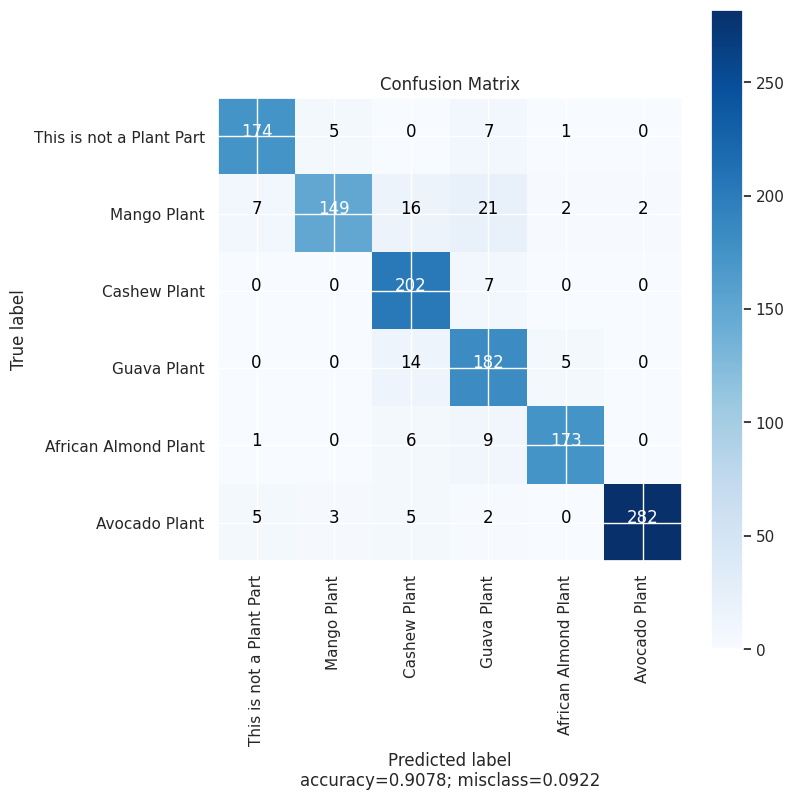

In [73]:
plot_confusion_matrix(cm,
                      normalize    = False,
                      target_names = ['This is not a Plant Part',
                                      'Mango Plant',
                                      'Cashew Plant',
                                      'Guava Plant',
                                      'African Almond Plant',
                                      'Avocado Plant'],
                      title        = "Confusion Matrix")

In [74]:
# Save Model
import tensorflow
from tensorflow import keras
from tensorflow.keras import models
models.save_model(model, '/content/drive/MyDrive/chatmodel/Plants.h5')

In [76]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/MyDrive/chatmodel/Plants.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("/content/drive/MyDrive/chatmodel/model.tflite", "wb").write(tflite_model)

89006332